# 人脸识别案例

    
本案例中，我们将学习构建一个基于深度学习技术的人脸识别模型，来对图像中人脸进行身份识别。目前人脸识别技术已被广泛应用于各种场景，如园区门禁系统、金融、智能安防等。
本案例将掌握MXNet AI引擎的用法（包括数据读取、模型训练和推理等功能）；掌握人脸识别模型的调参技巧，理解各个超参的含义。掌握如何基于MXNet构建一个人脸识别神经网络；掌握华为云ModelArts SDK的使用，如使用SDK创建训练作业、模型部署和模型测试等；掌握ModelArts自研的分布式训练框架MoXing的使用方法。

## 步骤

### 进入人工智能开发平台ModelArts界面

这步教大家如何进入人工智能开发平台华为云ModelArts服务。

第一步：点击“控制台”，如下图所示
![title](img/enter_modelarts_step1.png)

第二步：点击“所有服务”，如下图所示
![title](img/enter_modelarts_step2.png)

第三步：在“EI企业智能”大类下找到“ModelArts”，点击“ModelArts”，进入ModelArts服务主界面，如下图所示
![title](img/enter_modelarts_step3.png)

第四步：看到以下界面，说明成功进入了ModelArts服务主界面
![title](img/modelarts_index_page.png)



### 创建ModelArts Notebook

此步教大家如何在ModelArts中创建一个Notebook开发环境。ModelArts Notebook提供网页版的Python开发环境，无需用户自己搭建Python开发环境。

第一步：点击ModelArts服务主界面中的“开发环境”，如下图所示
![title](img/create_notebook_step1.png)

第二步：点击下图中的“创建”按钮
![title](img/create_notebook_step2.png)

第三步：填写创建Notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费 |
| 名称 | Notebook实例名称，如face_recognition |
| AI引擎 | 本案例使用MXNet引擎，Python版本3.6及以上 |
| 资源池 | 选择"公共资源池"即可|
| 类型 | 本案例使用较为复杂的深度神经网络模型，需要较高算力，选择"GPU" |
| 规格 | 选择"8核 &#124; 64GiB &#124; 1*p100" |
| 存储配置 | 选择EVS，磁盘规格5GB |

参数填写完毕后，点击下一步，查看Notebook实例预览信息

第四步：点击下图中的“立即创建”
![title](img/create_notebook_step4.png)

第五步：点击下图中的“返回Notebook列表”
![title](img/create_notebook_step5.png)

第六步：等待Notebook创建成功，创建成功后状态会变成“运行中”，如下图所示,直接点击Notebook名字，就可以进入Notebook界面
![title](img/create_notebook_step6.png)

### 在ModelArts Notebook中创建一个Notebook Python开发环境

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Notebook Python语言开发环境。先点击“New”按钮，然后根据本案例使用的AI引擎选择对应的环境

第三步：重命名刚刚创建的Notebook Python开发环境。点击“Untitled”，如下图所示
![title](img/create_notebook_dev_step2.png)

第四步：填写名称。我们可以填写一个跟本实验相关的名称，然后点击“Rename”按钮，如下图所示
![title](img/create_notebook_dev_step3.png)


### 如何在Notebook Python开发环境中写代码并执行代码
输入代码。我们打印一行字符串，按Shift+Enter(该组合键是Notebook中执行代码的快捷键)，查看代码执行结果。在代码输入框下面，可以看到代码执行结果，如下图所示
![title](img/type_code_step1.png)

###  准备源代码和数据

这一步准备案例所需的源代码和数据，相关资源已经保存在OBS中，我们通过ModelArts SDK将资源下载到本地，并解压到当前目录下。解压后，当前目录包含src和data两个目录，分别存有源代码和数据集。


In [1]:
from modelarts.session import Session
session = Session()
session.download_data(bucket_path='ai-course-common-20/face_recognition/face_recognition.tar.gz',
           path='./face_recognition.tar.gz')

# 使用tar命令解压资源包
!tar xf ./face_recognition.tar.gz

Successfully download file ai-course-common-20/face_recognition/face_recognition.tar.gz from OBS to local ./face_recognition.tar.gz
tar: data: Cannot utime: Operation not permitted
tar: data: Cannot change mode to rwsr-s---: Operation not permitted
tar: src: Cannot utime: Operation not permitted
tar: src: Cannot change mode to rwsr-s---: Operation not permitted
tar: Exiting with failure status due to previous errors


**Notebook Python开发环境就准备好了，接下来我们使用这个开发环境进行代码实践**

### 案例配置信息填写

案例中需要将运行结果上传至OBS中，这一步我们设置相关的参数（使用自己真实的桶名和唯一ID替换掉*号）：

- BUCKET_NAME：自己的OBS桶名
- UNIQUE_ID：唯一ID，填写自己的IAM子账号名称或者学号

In [2]:
BUCKET_NAME = '*'
UNIQUE_ID = '*'
OBS_BASE_PATH = BUCKET_NAME + '/' + UNIQUE_ID

### 导入基本工具库

执行下面方框中的这段代码，导入本次实验中使用的Python开发基本工具库。其中，MXNet框架是我们使用的AI编程框架，argparse库用于解析外部输入参数，src.face_resnet包含了人脸识别的卷积模型骨干。

In [3]:
import os
import mxnet as mx
import argparse
from src.face_resnet import get_symbol
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 脚本入参解析

该方法用来解析用户设置的训练所需的超参和数据路径等参数，如初始学习率、权重衰减系数、batch size等，使得这些参数可以从脚本外面控制，而不需要从代码中修改。

部分参数说明如下：

image_size：图像的大小；

lr： 学习率learning rate，表示梯度往某个方向更新的步长系数；

wd： 权值衰减系数weight decay，表示在损失函数计算时，L2归一化项的衰减系数；

epoch_image_num： 在一个epoch中，训练的数据量大小，一般为整个数据集的数据量大小；

num_classes： 分类数，表示本次数据集的类别数量；

num_epoch: epoch是模型训练整个数据集的一次迭代，num_epoch也就代表了整个训练过程对数据集的迭代次数，它的值越大那么模型学习就更加深，在训练集上拟合效果更加好，但过大的迭代次数也可能导致过拟合现象，也即是在训练集上表现好，在验证集或测试集等其他数据上表现很差；

学习率lr：模型一次训练得到的梯度代表了模型参数更新的方向和大小，而学习率是这个方向上更新大小的权值系数，太大的学习率会导致这次“迈出的一步”过大，太小则会导致“这一步”过小，也即是学习率对这一次参数更新大小起到了决定作用。于是很好理解，在一个epoch里若是参数更新次数不变化，更大的学习率，会使参数更新“走过的路程”更远，学习也更加深。
    
当然，学习率并不是越大越好，因为参数更新的方向是变化的，过大的学习率会导致学习不稳定。通常学习率大小都在0.1-0.0001之间调整。

per_batch_size: per_batch_size是指在每个GPU上一次训练一批数据的大小，调整这个值越大，表示一次训练的数据量也就越大，一次训练的数据量和训练有如下关系：
    
![title](img/batch_size.png)

这个公式代表了梯度更新的方法大小，m为batch_size大小，Var是指方差，显然当batch_size越大，方差也就越大，而众所周知方差越大，也就表示数据越稳定，在深度学习中也就表示训练得越稳定。

于是结合上面讲的学习率大小的调整，在显存可承受范围内，越大的batch_size使得学习更稳定情况下，学习率也可以随着调整得更大。
        

动量mom: 是动量的随机梯度下降中的一个参数，动量越小会使得模型参数的更新越稳定，过小的动量也会使得模型几乎不会学习，相反过大也会导致梯度波动也越大。动量大小大小一般在0.5-0.999之间调整，而常用的大小为0.9，太大太小都会导致模型训练不稳定。

num_layers: 表示使用的ResNet的卷积层层数，越大的层数模型越就越复杂，得到的精度可能更好，但是训练速度也相应更小了。
    
num_embed： 表示使用的人脸识别模型的嵌入层神经元数量，数值越大也就表示嵌入层表示的特征信息越丰富，而因此训练速度也会受到影响。

此段代码只设置脚本参数，无代码执行输出。

In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description='Train face network')
    parser.add_argument('--data_dir', default='data',
                        help='training set directory')# 训练数据路径
    parser.add_argument('--train_url', type=str, default='ckpt',
                        help='train path')# 训练模型输出路径
    parser.add_argument('--num_epoch', type=int, default=20,
                        help='training epoch size.')# 训练epoch数量
    parser.add_argument('--num_layers', type=int, default=18,
                        help='specify network layer, 18 50 100')# 使用的ResNet卷积层层数
    parser.add_argument('--image_size', default='112,112',
                        help='specify input image height and width')# 输入图像的大小，高、宽
    parser.add_argument('--lr', type=float, default=0.005,
                        help='start learning rate')# 训练开始的学习率大小
    parser.add_argument('--wd', type=float, default=0.0005,
                        help='weight decay')# 权值衰减系数
    parser.add_argument('--mom', type=float, default=0.9,
                        help='momentum')# 动量
    parser.add_argument('--per_batch_size', type=int, default=8,
                        help='batch size in each context')# 每一个GPU的batch size大小
    parser.add_argument('--epoch_image_num', type=int, default=200,
                        help='image size in one epoch')# 训练样本大小
    parser.add_argument('--train_file', type=str, default='celeb_train.rec',
                        help='train')# 训练数据文件
    parser.add_argument('--val_file', type=str, default='celeb_val.rec',
                        help='val')# 验证集文件
    parser.add_argument('--num_classes', type=int, default=5,
                        help='classes number')# 分类数
    parser.add_argument('--num_embed', type=int, default=8,
                        help='embedding number')# 嵌入层神经元数量
    parser.add_argument('--num_gpus', type=int, default=1,
                        help='GPUs number')# GPU数量
    parser.add_argument('--save_frequency', type=int, default=1,
                        help='save frequency')# 保存模型的频率
    parser.add_argument('--export_model', type=bool, default=False,
                        help='change train url to model,metric.json')#是否改变train url结构
    
    args, _ = parser.parse_known_args()
    return args

args = parse_args()

### 设置超参
设置训练需要的超参：

1. 设置模型训练的设备环境;
2. 设置训练时的batch size，固定图像大小的信息，和梯度归一化等参数
3. 设置优化器参数
4. 设置训练时的回调函数
5. 设置模型参数初始化方法

#### 设置模型训练使用的设备环境
这里设置模型所在的设备环境，会输出相应的设备号，如

    [cpu(0)]

或者

    [gpu(0)]
    
本案例中，我们使用GPU训练环境，这段代码会输出[gpu(0)]

In [5]:
# 模型所在的环境，指cpu或者哪块gpu
ctx = [mx.gpu(x) for x in range(args.num_gpus)] if args.num_gpus>0 else [mx.cpu()]
print(ctx)

[gpu(0)]


#### 设置训练时的batch size，固定图像大小的信息，和梯度归一化的参数

rescale grad含义：在多GPU设备的环境下，需要将梯度推送到参数服务器中做“和”操作，rescale grad表示在推送到参数服务器前先将梯度做一个相应的归一化，这里的归一化系数rescale grad的值为：1.0 / GPU的数量 / 每个GPU上batch_size的大小。

这里会输出batch size、image height、image width和rescale grad的信息

In [6]:
# 一次训练输入的batch size大小的数据
batch_size = int(args.per_batch_size * (args.num_gpus if args.num_gpus>0 else 1))
print('batch size: ', batch_size)
# 输入图像的高和宽
image_h, image_w = [int(x) for x in args.image_size.split(',')]
print('image height: ', image_h, ', image width: ', image_w)
# 梯度归一化参数，大小为1.0 / batch_size
_rescale = 1.0 / batch_size
print('rescale grad: ', _rescale)

batch size:  8
image height:  112 , image width:  112
rescale grad:  0.125


#### 设置优化器参数
设置本次训练的优化器参数，这里仅将学习率固定为某一个值，可以尝试减小或增大学习率来得到更好的训练结果。

本段代码执行后会输出优化器的所有参数信息，包含学习率、权值衰减系数等。

In [7]:
# 优化器参数，包含学习率调度器、权值衰减系数等
optimizer_params = {'learning_rate': args.lr,
                    'wd' : args.wd,
                    'lr_scheduler': None,
                    'clip_gradient': 5,
                    'momentum' : args.mom,
                    'multi_precision' : True,
                    'rescale_grad': _rescale,
                    }
print(optimizer_params)

{'learning_rate': 0.005, 'wd': 0.0005, 'lr_scheduler': None, 'clip_gradient': 5, 'momentum': 0.9, 'multi_precision': True, 'rescale_grad': 0.125}


#### 设置训练时的回调函数

训练时的回调函数中定义每一个step训练完后的操作和每一个epoch训练完后的操作，其中一个step指完成一个batch size大小数据的训练，一个epoch是指完成一遍整个数据集的训练。

每一个step训练完后：计算训练的吞吐量，在设置了模型评估方法后，也会计算相应的评估函数，如这里的准确度和交叉熵。

每一个epoch训练完后：保存已经训练好的模型文件。

此段代码只设置回调函数，无代码执行输出。

In [8]:
# 每一个step训练完后的操作
batch_end_callbacks = [mx.callback.Speedometer(batch_size, 10, auto_reset=True)]
# 每一个epoch训练完后的操作
# 这里的模型保存路径为模型输出文件目录下的model目录，模型文件以face开头
epoch_end_callbacks = mx.callback.do_checkpoint(
    os.path.join(args.train_url,'model/face'), args.save_frequency)
# 模型评估方法，准确度和交叉熵
eval_metrics = [mx.metric.Accuracy(), mx.metric.CrossEntropy()]

#### 设置模型初始化参数的方法

设置神经网络参数初始化方法，这里使用的是高斯分布的Xavier初始化方法。还可以选择其他方法如mx.init.MSRAPrelu()等，不同的初始化参数会有不同的模型训练结果。

此段代码只设置初始化参数方法，无代码执行输出。

In [9]:
# 模型参数的初始化方法
initializer = mx.init.Xavier(rnd_type='gaussian', factor_type="out", magnitude=2)

### 读取人脸数据集

#### 使用MXNet读取数据集

人脸识别数据集使用的是明星人脸图像集CelebFace，经过人脸3D对齐等操作制作成了适合分类模型训练的数据，每张图像的大小为112*112，样本图像如下：
    
![title](img/test.png) ![title](img/test2.png)

数据集格式为MXNet专用的rec格式，rec格式的数据集相比原图读取速度更快。

这里使用MXNet自带的mx.io.ImageRecordIter方法读取rec格式数据集，mx.io.ImageRecordIter可以在读取数据时就实现数据增强的方法，这里做了随机翻转、数据集重新洗牌等增强。
    
这里定义数据加载器的对象，加载成功会打印输出 “data loaded!”。

In [10]:
# 训练集和验证集的rec文件路径
path_imgrec = os.path.join(args.data_dir, args.train_file)
path_val_imgrec = os.path.join(args.data_dir, args.val_file)
# 使用mxnet自带的mx.io.ImageRecordIter加载数据
val_dataiter = mx.io.ImageRecordIter(
        path_imgrec=path_val_imgrec,
        data_shape=(3, image_h, image_w),
        batch_size=batch_size,
        resize=image_w,                 # 图像按照其最短边resize到定义好的宽长
        shuffle=False,
        preprocess_threads=2)
train_dataiter = mx.io.ImageRecordIter(
        path_imgrec=path_imgrec,
        data_shape=(3, image_h, image_w),
        num_parts=1,                    # 训练的节点数
        part_index=0,                   # 本机所在的节点id
        batch_size=batch_size,
        resize=image_w,
        rand_crop=False,
        rand_mirror=True,              # 图像随机翻转
        shuffle=True,                  # 数据集随机洗牌
        preprocess_threads=2)
print('data loaded!')

data loaded!


#### 查看数据集图像
matplotlib.pyplot可以绘制基本图形，读取上段代码数据加载器中的某张图片，并使用matplotlib.pyplot输出上面读取到的数据集中样本人脸图像。

此段代码会执行输出一张人脸图片。

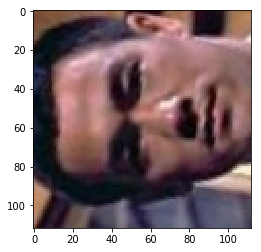

In [11]:
import matplotlib.pyplot as plt
next_data_batch = next(iter(train_dataiter))
img = next_data_batch.data[0][0].transpose(axes=(2,1,0))
img = img.asnumpy().astype('uint8')
# 画图，数据增强后的图片
%matplotlib inline
fig = plt.figure()
plt.imshow(img)
plt.show()

### 人脸识别神经网络构建

本教程介绍的人脸识别算法使用的模型骨干（backbone）为ResNet-50，我们基于业界流行的ResNet-50模型构建我们的人脸识别神经网络。

从本教程的src目录下的face_resnet.py源代码文件加载模型骨干，并将其分类层作为嵌入层，分类数设置为嵌入层神经元数。

在嵌入层后面接一个分类数为num_classes的分类层，就可以得到本实验的人脸识别神经网络了。

这里会输出一个 mx.mod.Module 对象。

In [12]:
# 初始化模型参数为None，这里可以加载预训练的模型参数
arg_params = None
aux_params = None
# 得到嵌入层模型的Symbol
embedding = get_symbol(num_classes=args.num_embed, num_layers=args.num_layers)
# 设置分类层的权值
_weight = mx.symbol.Variable("fc7_weight",
                             shape=(args.num_classes, args.num_embed),
                             lr_mult=1.0, wd_mult=1.0)
_bias = mx.symbol.Variable('fc7_bias', lr_mult=2.0, wd_mult=0.0)
# 全连接层
fc7 = mx.sym.FullyConnected(data=embedding, weight = _weight,
                            bias = _bias, num_hidden=args.num_classes, name='fc7')
all_label = mx.symbol.Variable('softmax_label')
softmax = mx.symbol.SoftmaxOutput(data=fc7, label = all_label, name='softmax')
# 输入模型环境和Symbol
model = mx.mod.Module(context=ctx, symbol=softmax)
print(model)

### 训练
使用mx.mod.Module类自带的fit函数进行训练，约在10个epoch左右，在验证集上可以达到0.75的准确率。

本段代码执行成功后，会在下方输出每一步训练的日志，如

    INFO:root:Epoch[0] Batch [10]	Speed: 1.38 samples/sec	accuracy=0.397727	cross-entropy=1.965782
    INFO:root:Epoch[0] Batch [20]	Speed: 1.49 samples/sec	accuracy=0.512500	cross-entropy=1.576477
    INFO:root:Epoch[0] Train-accuracy=0.583333
    INFO:root:Epoch[0] Train-cross-entropy=1.028852
    INFO:root:Epoch[0] Time cost=130.980
    INFO:root:Saved checkpoint to "s3://ai-course-001/face_recognition/ckpt/model/face-0001.params"
    INFO:root:Epoch[0] Validation-accuracy=0.583333
    INFO:root:Epoch[0] Validation-cross-entropy=1.360136

本段日志描述了模型训练的日志，每一步训练都输出了模型的准确率、模型交叉熵损失等，可以看到在每一步训练模型的准确率都越来越高，模型交叉熵损失越来越低，是模型训练得越来越好的标志。

In [13]:
model_output_dir = args.train_url + '/model/'

if os.path.exists(model_output_dir) == False:
    os.makedirs(model_output_dir)

model.fit(train_dataiter,
          begin_epoch        = 0,
          num_epoch          = args.num_epoch,
          eval_data          = val_dataiter,
          eval_metric        = eval_metrics,
          kvstore            = 'local',
          optimizer          = 'nag',
          optimizer_params   = optimizer_params,
          initializer        = initializer,
          arg_params         = arg_params,
          aux_params         = aux_params,
          allow_missing      = True,
          batch_end_callback = batch_end_callbacks,
          epoch_end_callback = epoch_end_callbacks )

INFO:root:Epoch[0] Batch [10]	Speed: 172.94 samples/sec	accuracy=0.443182	cross-entropy=2.185036
INFO:root:Epoch[0] Batch [20]	Speed: 179.97 samples/sec	accuracy=0.525000	cross-entropy=1.391039
INFO:root:Epoch[0] Train-accuracy=0.791667
INFO:root:Epoch[0] Train-cross-entropy=0.813433
INFO:root:Epoch[0] Time cost=1.912
INFO:root:Saved checkpoint to "ckpt/model/face-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.541667
INFO:root:Epoch[0] Validation-cross-entropy=2.005202
INFO:root:Epoch[1] Batch [10]	Speed: 207.27 samples/sec	accuracy=0.715909	cross-entropy=0.842773
INFO:root:Epoch[1] Batch [20]	Speed: 176.77 samples/sec	accuracy=0.750000	cross-entropy=0.836055
INFO:root:Epoch[1] Train-accuracy=0.666667
INFO:root:Epoch[1] Train-cross-entropy=0.889418
INFO:root:Epoch[1] Time cost=1.016
INFO:root:Saved checkpoint to "ckpt/model/face-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.562500
INFO:root:Epoch[1] Validation-cross-entropy=1.230389
INFO:root:Epoch[2] Batch [10]	Speed: 2

INFO:root:Epoch[17] Batch [10]	Speed: 197.45 samples/sec	accuracy=0.988636	cross-entropy=0.108683
INFO:root:Epoch[17] Batch [20]	Speed: 181.92 samples/sec	accuracy=1.000000	cross-entropy=0.075606
INFO:root:Epoch[17] Train-accuracy=1.000000
INFO:root:Epoch[17] Train-cross-entropy=0.059592
INFO:root:Epoch[17] Time cost=1.054
INFO:root:Saved checkpoint to "ckpt/model/face-0018.params"
INFO:root:Epoch[17] Validation-accuracy=0.687500
INFO:root:Epoch[17] Validation-cross-entropy=0.876016
INFO:root:Epoch[18] Batch [10]	Speed: 184.30 samples/sec	accuracy=0.988636	cross-entropy=0.062771
INFO:root:Epoch[18] Batch [20]	Speed: 194.51 samples/sec	accuracy=1.000000	cross-entropy=0.072895
INFO:root:Epoch[18] Train-accuracy=1.000000
INFO:root:Epoch[18] Train-cross-entropy=0.061150
INFO:root:Epoch[18] Time cost=1.024
INFO:root:Saved checkpoint to "ckpt/model/face-0019.params"
INFO:root:Epoch[18] Validation-accuracy=0.750000
INFO:root:Epoch[18] Validation-cross-entropy=0.768125
INFO:root:Epoch[19] Batc

接下来，我们将训练得到的模型上传到自己的OBS目录下：

In [14]:
import moxing as mox

# The obs_dst_path pattern： {BUCKET_NAME}/{UNIQUE_ID}/face_recognition/results/{TRAIN_URL}
obs_dst_path = "s3://" + OBS_BASE_PATH + "/face_recognition/results/" + args.train_url + '/'
mox.file.copy_parallel(args.train_url+'/model',
                      obs_dst_path)

INFO:root:Using MoXing-v1.12.4-85d16fc8
INFO:root:Using OBS-Python-SDK-3.1.2
INFO:root:Start to copy 21 files.
INFO:root:Finish copy.


<p style="font-family: Arial; font-size:1.4em;color:gold;">总结：训练完成后，在训练模型输出的OBS路径下（参考上述代码中的obs_dst_path），有model文件夹，model文件夹下面会有.params和.json后缀的模型文件。</p>

### 推理

模型推理共分为以下几个步骤：
1. 导入读取图片所需的库；
2. 输出测试的原图；
3. 将测试原图转换成模型需要的数据；
4. 加载推理使用的模型结构；
5. 推理计算并输出结果；

#### 导入读取图片所需的库
MoXing为华为自研的分布式深度学习框架，在这里用于notebook访问OBS。

mxnet.image里包含了一些常用的图像数据处理方法。

此段代码无回显。

In [15]:
import mxnet.image as image
import moxing as mox
import mxnet as mx
import matplotlib.pyplot as plt
import os

#### 输出测试的原图
这里使用matplotlib.pyplot来输出我们需要测试的图片，由于不能知道每张人脸的真实名字，用数字来替代

此段代码会输出一张人脸图像

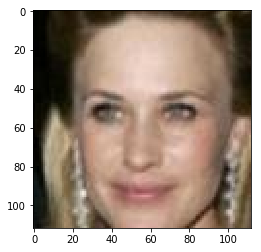

In [16]:
# 设置类别名，由于不能知道每张人脸的真实名字，用数字来替代
class_names = range(5)
# 人脸图像路径,这里可以任意选择一张人脸图像，并上传到自己的OBS路径
# 如s3://ai-course-001/face_recognition/data/下的test.png
file_name = args.data_dir + '/test.png'
# 以二进制形式，将图片读入内存
img = mox.file.read(file_name, binary=True)
# 查看图片
orig_img = mx.img.imdecode(img, to_rgb=1).asnumpy().astype('uint8')
plt.imshow(orig_img)
plt.show()

#### 将测试原图转换成模型推理需要的格式
这里使用mxnet.image来对测试原图进行增强，这里仅进行短边resize到定义好的固定的图像边大小112，之后再将图像翻转和维度扩展，最后得到模型需要的数据。

这里会输出 (NDArray 1x3x112x112 @cpu(0)) 格式数据；

In [17]:
# 图像处理
# 将图像处理成(3,112,112)大小
[h, w] = [112, 112]
img_arr = mx.img.imdecode(img, to_rgb=1)
# 首先转换成NDArray形式
img_arr = mx.img.resize_short(img_arr, w, 0)
# 翻转，经过翻转的图像不能通过plt显示
img_arr = mx.nd.transpose(img_arr, (2, 0, 1))
img_arr = mx.nd.expand_dims(img_arr, axis=0)
# 将图像绑定到cpu上
d = [img_arr.as_in_context(mx.cpu())]
print(d)

[
[[[[  4   0   0 ...,  84  74  62]
   [  4   0   0 ...,  59  52  45]
   [  3   0   1 ...,  35  33  32]
   ..., 
   [ 20  15  16 ..., 122 114 102]
   [ 22  13  10 ..., 120 110  99]
   [ 25  15   9 ..., 118 105  95]]

  [[  6   2   1 ...,  75  65  53]
   [  6   2   1 ...,  50  43  36]
   [  5   2   2 ...,  26  24  23]
   ..., 
   [ 24  19  18 ..., 104  96  83]
   [ 24  15  10 ..., 102  92  80]
   [ 27  17   9 ..., 100  87  76]]

  [[  3   0   0 ...,  58  48  36]
   [  3   0   0 ...,  33  26  19]
   [  2   0   0 ...,   9   9   8]
   ..., 
   [ 23  18  15 ...,  80  76  66]
   [ 23  14   8 ...,  78  72  63]
   [ 26  16   7 ...,  76  67  59]]]]
<NDArray 1x3x112x112 @cpu(0)>]


#### 加载推理使用的模型结构

加载训练得到的模型文件，用于推理。

这里只加载模型，无回显。

In [18]:
# 模型文件位置，比如由上面训练得到的位置train_url+'model',
# 这个路径位置下面必须有.json和.params的模型文件
ckpt = os.path.join(args.train_url, 'model/face')
# 加载第几个epoch
load_epoch = 1
# 加载模型文件,sym为推理模型结构，arg_params, aux_params为模型参数
sym, arg_params, aux_params = mx.model.load_checkpoint(ckpt, load_epoch)
# 选择使用cpu进行推理，数据名默认为data，推理无需输入label
mx_model = mx.mod.Module(symbol=sym, context=mx.cpu(),
                                      data_names=['data'], label_names=None)
# 绑定模型计算模块到底层计算引擎，绑定的数据大小默认为(1,3,112,112)
mx_model.bind(for_training=False, data_shapes=[('data',(1,3,112,112))])
# 设置模型的参数
mx_model.set_params(arg_params, aux_params, allow_missing=True)

#### 推理计算并输出结果
执行完这里会输出这张图片的分类结果和分类的可能性大小，模型输出整理成\[分类结果，置信度\]的形式。

这里会输出人脸图片的类别预测结果

In [19]:
# 模型结果后处理方法
def _postprocess(data):
    dim = len(data[0].shape)
    if dim > 2:
        data = mx.nd.array(np.squeeze(data.asnumpy(), axis=tuple(range(dim)[2:])))
    # 将得到的结果排序，选择可能性最大的类别
    sorted_prob = mx.nd.argsort(data[0], is_ascend=False)
    top_prob = list(map(lambda x: int(x.asscalar()), sorted_prob[0:2]))
    # 输出推理得到的类别和对应可能性
    return {"predicted_label": class_names[top_prob[0]],
            "scores": [[class_names[i], float(data[0, i].asscalar())] for i in top_prob]}

# 进行前向推理
mx_model.forward(mx.io.DataBatch(d))
# 输出
print(_postprocess(mx_model.get_outputs()[0]))

{'predicted_label': 3, 'scores': [[3, 0.6772790551185608], [0, 0.18954646587371826]]}


### 使用ModelArts SDK提交训练作业

本节介绍如何使用ModelArts SDK提交训练作业，其中模型的训练脚本使用ModelArts自研的分布式深度学习框架实现。训练脚本见src目录下的face_test_in_moxing.py文件，大家可以查看并学习。

分为以下几个步骤：

1. 导入ModelArts SDK库
2. 使用get_framework_list接口查询训练作业的引擎规格
3. 使用get_train_instance_types接口查询训练作业的设备资源规格
4. 提交训练作业
5. 输出训练作业的日志

#### 导入ModelArts SDK库

导入ModelArts SDK，以及创建SDK客户端。 初始化Session实现与华为云资源的鉴权。

此段代码无回显。

In [20]:
import urllib3
urllib3.disable_warnings()
from modelarts.session import Session
from modelarts.estimator import Estimator
from modelarts.predictor import Predictor
from modelarts.config.model_config import Params, ServiceConfig
import json
session = Session()

####  使用get_framework_list接口查询训练作业的引擎规格

此段代码打印训练作业支持的引擎规格列表。

In [21]:
print(json.dumps(Estimator.get_framework_list(session),indent = 1))

[
 {
  "framework_type": "TensorFlow",
  "framework_version": "TF-1.8.0-python2.7"
 },
 {
  "framework_type": "TensorFlow",
  "framework_version": "TF-1.8.0-python3.6"
 },
 {
  "framework_type": "MXNet",
  "framework_version": "MXNet-1.2.1-python2.7"
 },
 {
  "framework_type": "MXNet",
  "framework_version": "MXNet-1.2.1-python3.6"
 },
 {
  "framework_type": "Caffe",
  "framework_version": "Caffe-1.0.0-python2.7"
 },
 {
  "framework_type": "Spark_MLlib",
  "framework_version": "Spark-2.2.0-python2.7"
 },
 {
  "framework_type": "Scikit_Learn",
  "framework_version": "Scikit_Learn-0.18.1-python2.7"
 },
 {
  "framework_type": "XGBoost",
  "framework_version": "XGBoost-0.8-python2.7"
 },
 {
  "framework_type": "PyTorch",
  "framework_version": "PyTorch-1.0.0-python2.7"
 },
 {
  "framework_type": "PyTorch",
  "framework_version": "PyTorch-1.0.0-python3.6"
 }
]


####  使用get_train_instance_types接口查询训练作业的设备资源规格

此段代码打印训练作业支持的资源规格列表。

In [22]:
print(json.dumps(Estimator.get_train_instance_types(session),indent = 1))

[
 "modelarts.bm.gpu.8v100NV32",
 "modelarts.vm.cpu.2u",
 "modelarts.vm.gpu.p100"
]


#### 提交训练作业

提交训练作业需要填写训练作业的相关参数。其中部分参数说明如下：

hyperparameters为模型需要的超参,label表示参数名，value表示参数值，

    调整模型的学习率lr、模型迭代次数epoch、模型的batch size大小等都会改变模型训练结果，
    
    有时候调整适当的超参，模型可以达到非常高的精度，默认参数不是最佳参数。
    
训练规格train_instance_type，可以从上段代码的输出的specs字段中挑选一个训练规格（spec_code）

训练实例数量train_instance_count，默认为1

训练模型输出路径output_path，默认和train_url一样

启动成功后，会输出训练作业的启动日志，如JOBSTAT_INIT、JOBSTAT_RUNNING等。

In [23]:
# 训练任务根目录
base_url = BUCKET_NAME + '/' + UNIQUE_ID + '/face_recognition/train_models/'
session.create_directory(BUCKET_NAME, UNIQUE_ID + '/face_recognition/train_models/')


# 训练代码目录
app_url = base_url + 'src/'
# 训练代码启动文件
boot_file_url = app_url + 'face_test_in_moxing.py'
# 训练输出目录
train_url = base_url + 'ckpt/'
session.create_directory(BUCKET_NAME,  UNIQUE_ID + '/face_recognition/train_models/ckpt/')

# 数据集目录
data_url = base_url + 'data/'
#创建日志路径
session.create_directory(BUCKET_NAME,  UNIQUE_ID + '/face_recognition/train_models/log/')
# 日志目录
log_url = base_url + 'log/'

# 将源代码和数据上传到我们的OBS中，用于训练任务
mox.file.copy_parallel('./src', 's3://'+base_url+'src')
mox.file.copy_parallel(args.data_dir, 's3://'+base_url+args.data_dir)

Create directory */face_recognition/train_models/ successfully
Create directory */face_recognition/train_models/ckpt/ successfully
Create directory */face_recognition/train_models/log/ successfully


INFO:root:Start to copy 5 files.
INFO:root:Finish copy.
INFO:root:Start to copy 3 files.
INFO:root:Finish copy.


In [24]:
estimator = Estimator(modelarts_session=session,
                      framework_type='MXNet',
                      framework_version='MXNet-1.2.1-python3.6',
                      code_dir='/'+app_url,
                      boot_file='/'+boot_file_url,
                      log_url='/'+log_url,
                      hyperparameters=[{"label":"data_dir",
                                        "value":'s3://'+data_url},
                                       {"label":"train_url",
                                        "value":'s3://'+train_url},
                                       {"label":"lr","value":"0.001"},
                                       ],
                      output_path='/'+train_url, # 注意：output_path在OBS中要预先创建好
                      train_instance_type='modelarts.vm.gpu.p100',
                      train_instance_count=1,
                      job_description='test-face')
# 启动训练任务
job_id = estimator.fit(inputs='/'+data_url, wait=True)

JOBSTAT_INIT
JOBSTAT_WAITING
JOBSTAT_RUNNING
JOBSTAT_COMPLETED
Job [ job-0429-212046 ] duration is 00:01:02


上述代码执行完毕时，会不断输出训练任务的状态，直到状态为"COMPLETED"。

In [25]:
# 为模型准备config.json文件
mox.file.copy('./src/config.json', 's3://'+base_url+'ckpt/model/config.json')

####  输出训练作业的日志

此段可打印训练作业的日志

In [26]:
import os
obs_log_path = log_url

print(log_url)

local_log_path = "/tmp/log"
!rm -rf $local_log_path
!mkdir -p $local_log_path
session.download_data(obs_log_path, local_log_path)

log_file = os.listdir(local_log_path+'/log/')[0]
!cat $local_log_path/log/$log_file

*/*/face_recognition/train_models/log/


INFO:obs:Successfully download file */*/face_recognition/train_models/log/job-job-0429-012020V0001-0-0-99tjc_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-012020V0001-0-0-99tjc_default-stdout.log


Successfully download file */*/face_recognition/train_models/log/job-job-0429-012020V0001-0-0-99tjc_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-012020V0001-0-0-99tjc_default-stdout.log


INFO:obs:Successfully download file */*/face_recognition/train_models/log/job-job-0429-014504V0001-0-0-q7785_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-014504V0001-0-0-q7785_default-stdout.log
INFO:obs:Successfully download file */*/face_recognition/train_models/log/job-job-0429-100652V0001-0-0-w7728_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-100652V0001-0-0-w7728_default-stdout.log
INFO:obs:Successfully download file */*/face_recognition/train_models/log/job-job-0429-134751V0001-0-0-ltmwt_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-134751V0001-0-0-ltmwt_default-stdout.log
INFO:obs:Successfully download file */*/face_recognition/train_models/log/job-job-0429-144053V0001-0-0-tqfn4_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-144053V0001-0-0-tqfn4_default-stdout.log
INFO:obs:Successfully download file */*/face_recognition/train_models/log/job-job-0429-212046V0001-0-0-8qsgl_default-stdout.log from OBS to local /t

Successfully download file */*/face_recognition/train_models/log/job-job-0429-014504V0001-0-0-q7785_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-014504V0001-0-0-q7785_default-stdout.log
Successfully download file */*/face_recognition/train_models/log/job-job-0429-100652V0001-0-0-w7728_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-100652V0001-0-0-w7728_default-stdout.log
Successfully download file */*/face_recognition/train_models/log/job-job-0429-134751V0001-0-0-ltmwt_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-134751V0001-0-0-ltmwt_default-stdout.log
Successfully download file */*/face_recognition/train_models/log/job-job-0429-144053V0001-0-0-tqfn4_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-144053V0001-0-0-tqfn4_default-stdout.log
Successfully download file */*/face_recognition/train_models/log/job-job-0429-212046V0001-0-0-8qsgl_default-stdout.log from OBS to local /tmp/log/log/job-job-0429-212046V0001-0-0-8qsgl

### ModelArts的推理功能
在使用ModelArts推理功能之前需要保证train_url（模型输出路径）下的文件结构如下所示

         |--train_url
           |--model
              |--0000.params
              |--symbol.json
              |--config.json
              |--customize_service.py

    
source_location，模型所在的位置

execution_code，推理文件位置

instance_type，推理规格，可以在上述计算资源中找到，推荐使用cpu资源

instance_count，推理实例数量，默认为1

本节分为以下几个步骤：
1. 导入模型
2. 部署模型
3. 模型推理测试

#### 导入模型

导入训练作业生成的模型

这里会输出模型对象。

In [27]:
# 调用create_model接口将训练结果导入模型管理
model_path = BUCKET_NAME + "/" + UNIQUE_ID + "/face_recognition/train_models/ckpt/"
print(model_path)
model = estimator.create_model(model_algorithm = "face",
                                  source_location = model_path,
                                  execution_code = model_path + 'model/customize_service.py',
                                  model_type="MXNet")
print (model)

*/*/face_recognition/train_models/ckpt/
Model name is model-0429-212804 
The model source location is https://*.obs.myhwclouds.com/*/face_recognition/train_models/ckpt
publishing
published


#### 模型部署

使用ModelArts SDK部署模型为一个在线服务。

这段代码会输出模型部署日志。

In [28]:
# 调用deploy接口部署模型
configs = []
config1 = ServiceConfig(model_id=model.get_model_id(),
                        weight="100",
                        instance_count=1,
                        specification="modelarts.vm.cpu.2u",
                        envs={})
configs.append(config1)
service = estimator.deploy_predictor(service_name="celeb_face",
                                     description ="face recognition service",
                                     configs=configs)

Service name is celeb_face
Deploy progress: 100%
Deploy finished


#### 测试人脸识别服务

我们选用本地data目录下的test.png，用ModelArts SDK调用服务的API：

In [29]:
from modelarts.model import Predictor
predictor_instance = Predictor(session, service.service_id)
predict_result = predictor_instance.predict(
    data = "./data/test.png",
    data_type = "images")
print(predict_result)

{'predicted_label': 4, 'scores': [[4, 0.9799331426620483], [1, 0.01852753385901451], [3, 0.0013976095942780375]]}


### 删除推理资源 (可选)
在使用完成后，及时删除推理使用的资源，可以节约费用。

In [30]:
estimator.delete(job_id=job_id, model_id=model.model_id, service_id=service.service_id)

Successfully delete the job 105495
Delete the service 04c4f576-eaf7-4137-aab2-e7f832020b53 endpoint successfully.
Delete the model ef5c200b-e6a0-4733-8198-da7e7900b106 endpoint successfully.


### 小结

在本次实验中，我们展示了如何使用深度学习技术构建一个人脸识别应用的全流程，并解释了模型中各个超参的含义，让大家具备了基本的调参能力。

同时学习了ModelArts SDK的使用，以及如何通过SDK提交训练作业至ModelArts训练人脸识别模型，并将训练好的人脸识别模型使用SDK在ModelArts上部署成在线服务，并做推理测试。